# 07.3h: Degenerate Structure Connectivity Analysis

**Goal:** Analyze the unified degenerate structure (kissing cluster + black holes) as one connected graph.

We now know that all 2,100 black holes are at the same location as the 111 kissing cousins. This is one structure with 2,211 tokens total:
- **Inner core:** 2,100 black holes (bfloat16-indistinguishable)
- **Outer shell:** 111 kissing cousins (distinguishable but lattice-saturated at ~2× ULP)

**Questions:**
1. How many unique vectors do the 2,100 black holes collapse to?
2. When we combine deduplicated black holes + kissing cousins, do they form one fully connected graph?
3. What is the graph structure? Core-periphery? Layered? Or still maximally connected?

**Method:**
- Deduplicate black holes to unique vectors (but track degeneracy)
- Compute L∞ distances between all pairs (deduplicated BH + kissing cousins)
- Build adjacency graph with threshold = 2× ULP
- Analyze graph properties: connectivity, degree distribution, components

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Kissing cluster
KISSING_FILE = "kissing_cluster_lat23_lon164.safetensors"
KISSING_KEY = "token_ids"

# Black holes
BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"
BLACK_HOLE_MASK_KEY = "mask"

# Gamma matrix
GAMMA_FILE = "gamma_centered_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma_centered"

# Kissing threshold (from 07.3e)
# Mean radius of cluster ≈ 0.122, so ulp ≈ 2^(-12) ≈ 2.44e-4
# But compute it precisely from actual vectors
ULP_MULTIPLIER = 2.0  # "Kissing" = L∞ ≤ 2× ULP

RANDOM_SEED = 42

## Imports

In [2]:
import torch
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

# Load kissing cluster token IDs
print("Loading kissing cluster token IDs...")
kissing_data = load_file(data_dir / KISSING_FILE)
kissing_ids = kissing_data[KISSING_KEY]
n_kissing = len(kissing_ids)
print(f"  Kissing cluster: {n_kissing} tokens")
print()

# Load black hole mask
print("Loading black hole mask...")
bh_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = bh_data[BLACK_HOLE_MASK_KEY]
n_black_holes = black_hole_mask.sum().item()
black_hole_ids = torch.where(black_hole_mask)[0]
print(f"  Black holes: {n_black_holes:,} tokens")
print()

# Load gamma matrix
print("Loading gamma matrix...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]
N, d = gamma.shape
print(f"  Shape: ({N:,}, {d:,})")
print()

Loading kissing cluster token IDs...
  Kissing cluster: 111 tokens

Loading black hole mask...
  Black holes: 2,100 tokens

Loading gamma matrix...
  Shape: (151,936, 2,560)



## Extract Vectors

In [4]:
print("Extracting kissing cluster vectors...")
kissing_vectors = gamma[kissing_ids]
print(f"  Shape: {kissing_vectors.shape}")
print()

print("Extracting black hole vectors...")
black_hole_vectors = gamma[black_hole_mask]
print(f"  Shape: {black_hole_vectors.shape}")
print()

Extracting kissing cluster vectors...
  Shape: torch.Size([111, 2560])

Extracting black hole vectors...
  Shape: torch.Size([2100, 2560])



## Deduplicate Black Holes

Black holes are tokens that became bfloat16-indistinguishable during training. Multiple token IDs map to the same vector. We need to:
1. Find unique vectors
2. Track which token IDs map to each unique vector (degeneracy)

In [5]:
print("Deduplicating black hole vectors...")
print("  Computing unique vectors...")

# torch.unique on full vectors
unique_bh_vectors, inverse_indices = torch.unique(black_hole_vectors, dim=0, return_inverse=True)
n_unique_bh = len(unique_bh_vectors)

print(f"  Unique black hole vectors: {n_unique_bh}")
print(f"  Total black hole tokens:   {n_black_holes:,}")
print(f"  Degeneracy (avg):          {n_black_holes / n_unique_bh:.1f} tokens per unique vector")
print()

# Track degeneracy: how many tokens map to each unique vector?
degeneracy_counts = torch.bincount(inverse_indices)
print(f"  Degeneracy statistics:")
print(f"    Min:    {degeneracy_counts.min().item()} tokens")
print(f"    Max:    {degeneracy_counts.max().item()} tokens")
print(f"    Mean:   {degeneracy_counts.float().mean().item():.1f} tokens")
print(f"    Median: {degeneracy_counts.float().median().item():.0f} tokens")
print()

Deduplicating black hole vectors...
  Computing unique vectors...
  Unique black hole vectors: 13
  Total black hole tokens:   2,100
  Degeneracy (avg):          161.5 tokens per unique vector

  Degeneracy statistics:
    Min:    2 tokens
    Max:    814 tokens
    Mean:   161.5 tokens
    Median: 6 tokens



## Combine Deduplicated Black Holes + Kissing Cousins

In [6]:
print("Combining deduplicated black holes + kissing cousins...")
combined_vectors = torch.cat([unique_bh_vectors, kissing_vectors], dim=0)
n_combined = len(combined_vectors)

print(f"  Unique black holes: {n_unique_bh}")
print(f"  Kissing cousins:    {n_kissing}")
print(f"  Combined total:     {n_combined}")
print()

# Create labels for visualization
# 0 to n_unique_bh-1: black holes
# n_unique_bh to n_combined-1: kissing cousins
labels = torch.cat([
    torch.zeros(n_unique_bh, dtype=torch.long),  # 0 = black hole
    torch.ones(n_kissing, dtype=torch.long)       # 1 = kissing cousin
])
print(f"  Labels shape: {labels.shape}")
print()

Combining deduplicated black holes + kissing cousins...
  Unique black holes: 13
  Kissing cousins:    111
  Combined total:     124

  Labels shape: torch.Size([124])



## Compute bfloat16 ULP at Cluster Location

In [7]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP spacing for scalar value x."""
    if x == 0:
        return 2.0 ** (-133)  # Minimum subnormal
    exponent = np.floor(np.log2(np.abs(x)))
    return 2.0 ** (exponent - 6)

# Estimate ULP from typical component magnitude in cluster
typical_magnitude = combined_vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
kissing_threshold = ULP_MULTIPLIER * ulp

print(f"Kissing threshold calculation:")
print(f"  Typical component magnitude: {typical_magnitude:.6e}")
print(f"  bfloat16 ULP at this scale:  {ulp:.6e}")
print(f"  Kissing threshold (2× ULP):  {kissing_threshold:.6e}")
print()

Kissing threshold calculation:
  Typical component magnitude: 2.361155e-03
  bfloat16 ULP at this scale:  3.051758e-05
  Kissing threshold (2× ULP):  6.103516e-05



## Compute L∞ Distance Matrix

This is the expensive part: N² distances for N = n_unique_bh + n_kissing ≈ ? + 111.

We'll compute the full pairwise L∞ distance matrix.

In [8]:
print(f"Computing L∞ distance matrix for {n_combined} vectors...")
print(f"  This is {n_combined}² = {n_combined**2:,} pairwise distances.")
print()

# Compute pairwise L∞ distances
v1 = combined_vectors.unsqueeze(1)  # [n, 1, d]
v2 = combined_vectors.unsqueeze(0)  # [1, n, d]
diffs = torch.abs(v1 - v2)           # [n, n, d]

print("  Computing L∞ norm (max over dimensions)...")
l_inf_distances = diffs.max(dim=2)[0]  # [n, n]

print(f"  Distance matrix shape: {l_inf_distances.shape}")
print()

# Mask diagonal (distance to self = 0, not interesting)
mask = torch.eye(n_combined, dtype=torch.bool)
l_inf_distances_no_diag = l_inf_distances.clone()
l_inf_distances_no_diag[mask] = float('inf')  # Exclude self-distances from stats

print(f"  L∞ distance statistics (excluding diagonal):")
print(f"    Min:    {l_inf_distances_no_diag.min().item():.6e}")
print(f"    Max:    {l_inf_distances_no_diag.max().item():.6e}")
print(f"    Mean:   {l_inf_distances_no_diag[~torch.isinf(l_inf_distances_no_diag)].mean().item():.6e}")
print(f"    Median: {l_inf_distances_no_diag[~torch.isinf(l_inf_distances_no_diag)].median().item():.6e}")
print()

Computing L∞ distance matrix for 124 vectors...
  This is 124² = 15,376 pairwise distances.

  Computing L∞ norm (max over dimensions)...
  Distance matrix shape: torch.Size([124, 124])

  L∞ distance statistics (excluding diagonal):
    Min:    7.450581e-09
    Max:    inf
    Mean:   2.621750e-05
    Median: 3.051758e-05



## Build Adjacency Graph

Create adjacency matrix: edge exists if L∞ distance ≤ kissing threshold (2× ULP) and not self-loop.

In [9]:
print("Building adjacency graph...")
print(f"  Threshold: {kissing_threshold:.6e}")
print()

# Adjacency: 1 if kissing, 0 otherwise (exclude diagonal)
adjacency = (l_inf_distances <= kissing_threshold) & (~mask)

# Count edges
n_edges = adjacency.sum().item() // 2  # Divide by 2 because undirected
n_possible_edges = n_combined * (n_combined - 1) // 2
density = n_edges / n_possible_edges

print(f"Graph statistics:")
print(f"  Nodes:          {n_combined}")
print(f"  Edges:          {n_edges:,}")
print(f"  Possible edges: {n_possible_edges:,}")
print(f"  Density:        {density:.4f} ({100*density:.2f}%)")
print()

if density == 1.0:
    print("  ✓ COMPLETE GRAPH: Every node is connected to every other node!")
elif density > 0.9:
    print("  ~ NEARLY COMPLETE: Very high connectivity.")
else:
    print("  ○ Partial connectivity detected.")
print()

Building adjacency graph...
  Threshold: 6.103516e-05

Graph statistics:
  Nodes:          124
  Edges:          7,623
  Possible edges: 7,626
  Density:        0.9996 (99.96%)

  ~ NEARLY COMPLETE: Very high connectivity.



## Degree Distribution

In [10]:
print("Computing node degrees...")
degree = adjacency.sum(dim=1)

print(f"  Degree statistics:")
print(f"    Min:    {degree.min().item()}")
print(f"    Max:    {degree.max().item()}")
print(f"    Mean:   {degree.float().mean().item():.1f}")
print(f"    Median: {degree.float().median().item():.0f}")
print()

# Separate by type
bh_degrees = degree[:n_unique_bh]
kissing_degrees = degree[n_unique_bh:]

print(f"  Black hole degrees:")
print(f"    Min:    {bh_degrees.min().item()}")
print(f"    Max:    {bh_degrees.max().item()}")
print(f"    Mean:   {bh_degrees.float().mean().item():.1f}")
print()

print(f"  Kissing cousin degrees:")
print(f"    Min:    {kissing_degrees.min().item()}")
print(f"    Max:    {kissing_degrees.max().item()}")
print(f"    Mean:   {kissing_degrees.float().mean().item():.1f}")
print()

Computing node degrees...
  Degree statistics:
    Min:    120
    Max:    123
    Mean:   123.0
    Median: 123

  Black hole degrees:
    Min:    123
    Max:    123
    Mean:   123.0

  Kissing cousin degrees:
    Min:    120
    Max:    123
    Mean:   122.9



## Degree Distribution Histogram

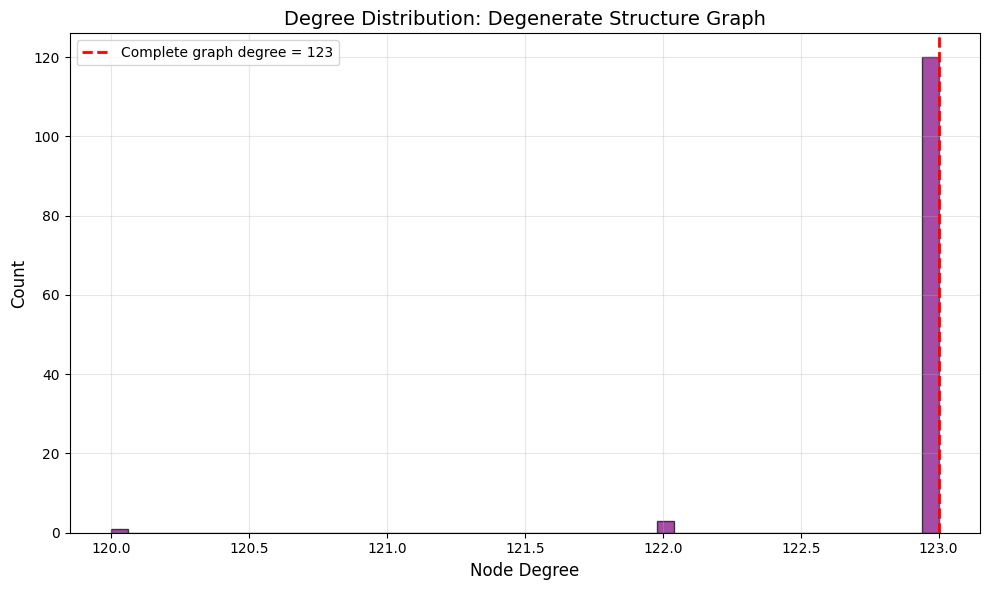

In [11]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Histogram
ax.hist(degree.cpu().numpy(), bins=50, alpha=0.7, color='purple', edgecolor='black')

# Mark expected degree for complete graph
expected_degree = n_combined - 1
ax.axvline(expected_degree, color='red', linestyle='--', linewidth=2,
           label=f'Complete graph degree = {expected_degree}')

ax.set_xlabel('Node Degree', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Degree Distribution: Degenerate Structure Graph', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Distance Distribution Histogram

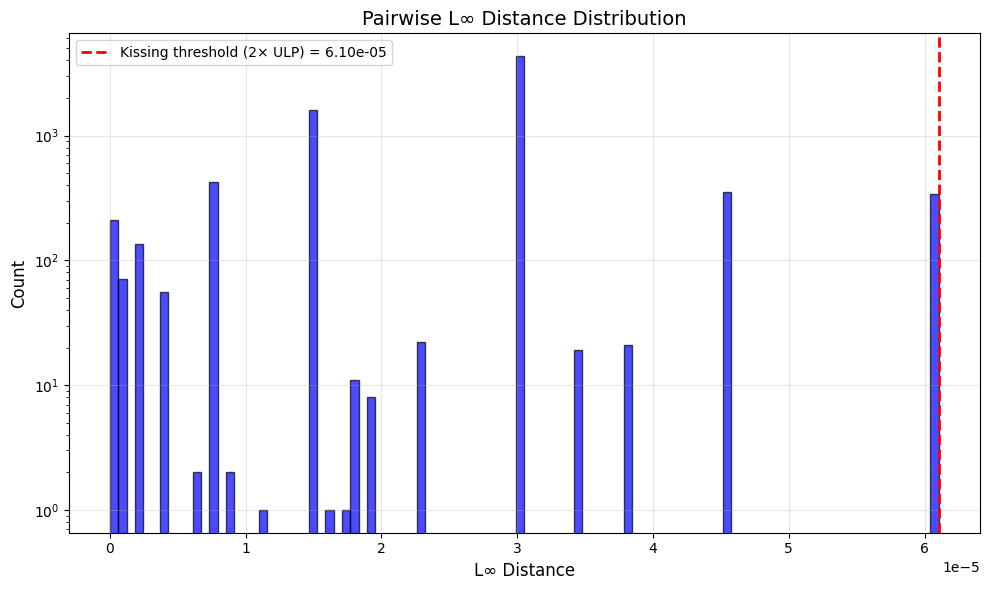

In [12]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Flatten distance matrix (exclude diagonal and upper triangle to avoid duplicates)
tril_indices = torch.tril_indices(n_combined, n_combined, offset=-1)
distances_flat = l_inf_distances[tril_indices[0], tril_indices[1]]

# Histogram
ax.hist(distances_flat.cpu().numpy(), bins=100, alpha=0.7, color='blue', edgecolor='black')

# Mark kissing threshold
ax.axvline(kissing_threshold, color='red', linestyle='--', linewidth=2,
           label=f'Kissing threshold (2× ULP) = {kissing_threshold:.2e}')

ax.set_xlabel('L∞ Distance', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Pairwise L∞ Distance Distribution', fontsize=14)
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Connectivity Analysis: Black Holes ↔ Kissing Cousins

Are black holes and kissing cousins connected to each other, or do they form separate components?

In [13]:
print("Analyzing connectivity between black holes and kissing cousins...")
print()

# Extract submatrices
# BH-BH block: [0:n_unique_bh, 0:n_unique_bh]
# KC-KC block: [n_unique_bh:, n_unique_bh:]
# BH-KC block: [0:n_unique_bh, n_unique_bh:] and [n_unique_bh:, 0:n_unique_bh]

bh_bh_adj = adjacency[:n_unique_bh, :n_unique_bh]
kc_kc_adj = adjacency[n_unique_bh:, n_unique_bh:]
bh_kc_adj = adjacency[:n_unique_bh, n_unique_bh:]

# Count edges within and between groups
n_edges_bh_bh = bh_bh_adj.sum().item() // 2
n_edges_kc_kc = kc_kc_adj.sum().item() // 2
n_edges_bh_kc = bh_kc_adj.sum().item()  # Already counting one direction

print(f"Edges within black holes:         {n_edges_bh_bh:,}")
print(f"Edges within kissing cousins:     {n_edges_kc_kc:,}")
print(f"Edges between BH and KC:          {n_edges_bh_kc:,}")
print()

# Possible edges
n_possible_bh_bh = n_unique_bh * (n_unique_bh - 1) // 2
n_possible_kc_kc = n_kissing * (n_kissing - 1) // 2
n_possible_bh_kc = n_unique_bh * n_kissing

density_bh_bh = n_edges_bh_bh / n_possible_bh_bh if n_possible_bh_bh > 0 else 0
density_kc_kc = n_edges_kc_kc / n_possible_kc_kc if n_possible_kc_kc > 0 else 0
density_bh_kc = n_edges_bh_kc / n_possible_bh_kc if n_possible_bh_kc > 0 else 0

print(f"Density within black holes:       {density_bh_bh:.4f} ({100*density_bh_bh:.2f}%)")
print(f"Density within kissing cousins:   {density_kc_kc:.4f} ({100*density_kc_kc:.2f}%)")
print(f"Density between BH and KC:        {density_bh_kc:.4f} ({100*density_bh_kc:.2f}%)")
print()

if density_bh_kc > 0.9:
    print("  ✓ Black holes and kissing cousins are HIGHLY CONNECTED.")
    print("    They form one unified structure, not separate components.")
elif density_bh_kc > 0.5:
    print("  ~ Black holes and kissing cousins have MODERATE connectivity.")
    print("    Some connections between groups but not fully merged.")
else:
    print("  ✗ Black holes and kissing cousins are WEAKLY CONNECTED.")
    print("    They may form distinct substructures (core vs shell).")
print()

Analyzing connectivity between black holes and kissing cousins...

Edges within black holes:         78
Edges within kissing cousins:     6,102
Edges between BH and KC:          1,443

Density within black holes:       1.0000 (100.00%)
Density within kissing cousins:   0.9995 (99.95%)
Density between BH and KC:        1.0000 (100.00%)

  ✓ Black holes and kissing cousins are HIGHLY CONNECTED.
    They form one unified structure, not separate components.



## Conclusion

**Key findings:**

1. **Degeneracy:** How many unique vectors do the 2,100 black holes collapse to?
2. **Graph structure:** Is the combined structure (deduplicated BH + KC) a complete graph? Nearly complete? Or layered?
3. **Core-shell structure:** Are BH and KC highly connected to each other, or do they form separate subgraphs?

**Interpretation:**
- If still complete graph (density ≈ 1.0) → entire structure is maximally connected at lattice scale
- If high density within groups but lower between → core-periphery structure (BH core, KC shell, weak coupling)
- If partial connectivity → more complex geometry (clusters, layering, etc.)

**Next steps:**
- Decode tokens to understand semantic collapse
- Search for other degenerate structures in token space
- Investigate training dynamics: why did these tokens collapse?